# Solving the Schrödinger equation by brute force

In this notebook we will learn how to

* create a normalized wavefunction (`normalize`),
* create the Hamiltonian using differentiation matrices (`diffmatrix`) and diagonal matrices (`expsolve.linalg.diag`),
* compute its exponential (`torch.matrix_exp`),
* and apply it to a vector (`expsolve.linalg.matmul`).

[Back to tensorgrid quick introduction](00_quick_introduction.ipynb). 

*&#169; Copyright 2019-2023 Pranav Singh*

Use of this source code is governed by the MIT license that can be found in the LICENSE file.

In [1]:
import time 

import numpy as np

import matplotlib.pyplot as plt

import expsolve as es
import expsolve.discretize.tensorgrid as ex

import torch
from torch import exp, sin, cos, abs, real, imag, pi, max, diag
from torch.linalg import norm, matrix_exp

c:\ProgramData\Anaconda3\envs\torchcomplex\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## The linear time-dependent Schrödinger equation (TDSE)

The linear time-dependent Schrödinger equation in 1D with periodic boundaries over a domain $[-L,L]$ can be written as

$$ i \partial_t \psi(x,t) = \mathrm{H} \psi(x,t), \qquad x \in [-L,L] $$

where $\mathrm{H}$ is the Hamiltonian operator

$$ \mathrm{H} = -\partial_x^2 + V(x) $$

and $V(x)$ is a (typically real-valued) potential function. Typically, we spatially discretise the PDE, replacing the Hamiltonian operator $\mathrm{H}$ with a discretised Hamiltonian matrix $\mathbf{H}$, and arriving at the system of ODEs:

$$ i \partial_t u(t) = \mathbf{H} u(t), $$

where $u(t)$ is now a vector of values on the spatial grid, and the discretised Hamiltonian matrix is

$$ \mathbf{H} = -\mathrm{D}_2 + \texttt{diag}(V). $$

The exact solution of this system of ODEs is given by the matrix exponential:

$$ u(t) = \exp\left(-i t \mathbf{H}\right) u(0). $$

## An example using a brute force approach

The brute force approach for solving the Schrödinger equation consists of directly computing the matrix exponential. We can do this using the matrix exponentiation function `matrix_exp` in `torch`.

### Grid

In [2]:
n = 200
L = 10
xr = [-L, L]
x = ex.grid1d(n, xr)

### Initial Condition

#### $\star$ `normalize`

In quantum mechanics we typically want the wavefunction to be normalized, $\|u\|_{L^2} = 1$. This can be achieved with the `normalize` function,

```Python
    un = ex.normalize(u, xrange)
```
By default this function also makes the wavefunction complex-valued. This choice has been kept as the default one since normalization is used much more frequently in quantum mechanics, where the solution $u$ is complex-valued. 

If real-valued normalized solution is required, set the (optional) `keepreal` parameter to `True` (`un = ex.normalize(u, xrange, keepreal=True)`).

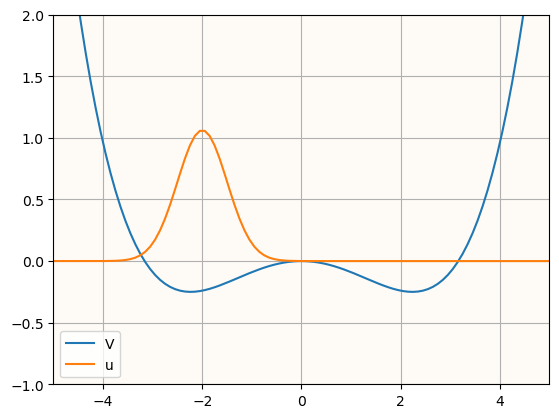

In [3]:
x0 = -2.0
u = exp(-(x-x0)**2/(2*0.25))
u = ex.normalize(u, xr)         # normalize also makes it complex

V = x**4 - 10*x**2

fig, ax = plt.subplots()
ex.plot(ax, x, V/100)
ex.plot(ax, x, abs(u))
plt.xlim(-5,5)
plt.ylim(-1,2)
plt.legend(['V','u'])
plt.show()

### Brute force solution using `matrix_exp`

First we create the Hamiltonian matrix: 

$$ \mathbf{H} = -\mathrm{D}_2 + \texttt{diag}(V). $$

In [4]:
D2 = ex.diffmatrix(2, n, xr)
H = -D2 + es.linalg.diag(V)

Now we can compute the matrix exponential $\exp\left(-i t \mathbf{H}\right)$ using `torch`s `matrix_exp` function and compute the solution as

$$ u(t) = \exp\left(-i t \mathbf{H}\right) u(0). $$

In [5]:
T = 1.0
uT = es.linalg.matmul(matrix_exp(-1j*T*H), u)    

Let's plot the solution at $T=1$:

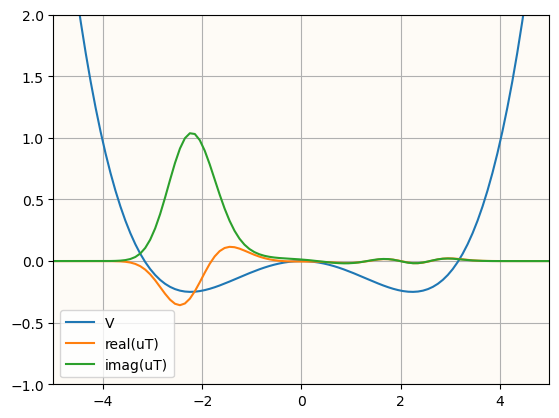

In [6]:
fig, ax = plt.subplots()
ex.plot(ax, x, V/100)
ex.plot(ax, x, real(uT))
ex.plot(ax, x, imag(uT))
plt.xlim(-5,5)
plt.ylim(-1,2)
plt.legend(['V','real(uT)','imag(uT)'])
plt.show()